In [1]:
# Insérez ici le numéro de votre équipe
VOTRE_NUMERO_EQUIPE = 4
# modifier cette variable selon que vous contrôler la simulation ou le robot réel
SIM = True
VOTRE_NUMERO_DINGO = 6

## Import des paquets Python

In [2]:
# Import des paquets requis et configuration du ROS Master
import sys
sys.path.append('/opt/rosssh mecbot@cpr-ets05-0X/noetic/lib/python3/dist-packages/')
sys.path.append('/opt/ros/noetic/lib/python3/dist-packages/')
sys.path.append('/usr/lib/python3/dist-packages')
from os import environ
if SIM:
    environ['ROS_MASTER_URI'] = "http://localhost:1137{}/".format(VOTRE_NUMERO_EQUIPE)
else:
    environ['ROS_MASTER_URI'] = "http://cpr-ets05-0{}:11311/".format(VOTRE_NUMERO_DINGO)
    environ['ROS_IP'] = "192.168.0.84" # adresse IP de votre station de travail
import rospy
import numpy as np
from std_msgs.msg import Float32MultiArray
from jackal_msgs.msg import Drive
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Pose, PoseStamped, PoseWithCovarianceStamped
from sensor_msgs.msg import Imu
from sensor_msgs.msg import CompressedImage
from sensor_msgs.msg import LaserScan
from apriltag_ros.msg import AprilTagDetectionArray
from scipy.spatial.transform import Rotation as R
from lab_utils.plan_utils import *
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.artist import Artist
import matplotlib.animation as animation
import cv2
from lab_utils.rrt import RRTPlanner
from ipywidgets import HBox, Box, Layout, GridspecLayout, AppLayout
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import ipywidgets as widgets
import threading
import time
import warnings
import os
import copy


In [3]:
# Créer et démarrer un nouveau noeud
rospy.init_node('dingo_controller', anonymous=True)

# Variables Globales

In [4]:
# Caractéristiques du robot
interwheel_distance = 0.46
left_wheel_radius = 0.045
right_wheel_radius = 0.045

# Parametres de vitesse
vel_lin=0.3
vel_ang=0.3

# Parametres de position
theta = 0
x=0
y=0

#Relation dimension carte/environnement
px = 0.02 
if SIM == True:
    start_x = 27.6 
    start_y = 22.6
else:
    start_x = 27.46
    start_y = 25.40
end_x = 35
end_y = 32
x_len = 40.96
y_len = 42.24

#Position de départ selon l'axe y prédéfinies du robot
pos_depart_y = [start_y-6.3, start_y-5.45, start_y-4.6, start_y-3.75,
                start_y-2.96, start_y-1.97, start_y-1.12, start_y-0.22]

#Variables de test
nb_pt_parcouru = 0
x_test = 0
y_test = 0

#PATH images et gestion des cartes
image_name ="a2230_map_closed_fliped.png" 
image_calcul = "a2230_map_closed_fliped_CALCUL_25.png"
image_travel = "a2230_map_closed_fliped_travel.png" #"a2230_map_closed_fliped.png" #"a2230_map_closed_fliped_travel.png"
image_read = mpimg.imread(image_name)
image_calcul_read = mpimg.imread(image_calcul)

fig_c = None
ax_pos_current = None

#Étâts du robot en simulation
etats_robot = ['Robot arrété, replanifier la trajectoire', 'Trajectoire planifiée, démarrer le robot', 'Robot en cours de déplacement']
texte_etats_robot = etats_robot[0]

# gestion des tags
liste_tag = []
tag_dict = {
    2 : 'Porte',
    7 : 'Boite classe',
    9 : 'Boite couloir - Est',
    6 : 'Boite couloir - Nord',
    8 : 'Fond de la classe' #'Boite couloir - Ouest',
}
Label_tag_description = 'Liste des April Tag vus:\n'

#Fréquence de l'odométrie du robot
if SIM == True:
    frequence = 50
else:
    frequence = 200

# Flqg pour le contrôle du robot
flag_follow_map = False
stop = False
stop_obstacle = False
new_plannification = False
plannification_in_progress = False

## Création des 'callbacks'
Chaque fonction est associée à un sujet ROS et enregistre en continue sont contenu dans une variable globale.

## Calculs d'angles

In [5]:
# Fonction pour le calcul de l'orientation à partir d'un quaternion
# Entrée : Quaternion [x, y ,z ,w]
# Sortie : Angle de lacet (yaw) en radians
def get_heading_from_quaternion(q):
    r = R.from_quat([q.x, q.y, q.z, q.w])
    angles = r.as_euler('xyz', degrees=False)
    return angles[2]

def wraptopi(angle):
    xwrap=np.remainder(angle, 2*np.pi)
    if np.abs(xwrap)>np.pi:
        xwrap -= 2*np.pi * np.sign(xwrap)
    return xwrap

## Callback position et orientation

In [6]:
#Realsense Pose subscriber callback
pose_msg = Pose()
def pose_callback(msg):
    global x, y, theta, x_test, y_test, pos_depart_y
    pose_msg = msg.pose.pose
    
#     if SIM == False:
    start_y = pos_depart_y[int(select_pos.value)-1]
    
    x = pose_msg.position.x+start_x #add start point in meters
    y = pose_msg.position.y+start_y #add start point in meters
    x_test = pose_msg.position.x
    y_test = pose_msg.position.y
    theta = get_heading_from_quaternion(pose_msg.orientation)

## Callabck laser de détection d'obstacles

In [7]:
# Laser scan subscriber callback
laser_msg = LaserScan()

range_laser = 85.1988 #deg
inc_laser = 0.066562

cone = 70
angle_min = -cone/2 #deg
angle_max =  cone/2 #deg

if SIM:
    dist_obstacle = 0.5 #m
else:
    dist_obstacle = 0.5 #m

index_angle_min = (np.floor(angle_min+range_laser/2/inc_laser)).astype(int)
index_angle_max = (np.ceil(angle_max+range_laser/2/inc_laser)).astype(int)

def laser_scan_callback(msg):
    global laser_msg, stop_obstacle, milieu, tableau_stop
    laser_msg = msg
    
    # Tableau de mesures du milieu
    milieu = list(laser_msg.ranges[index_angle_min:index_angle_max])
    milieu = [x for x in milieu if not np.isnan(x)]
    if not len(milieu):
        milieu=[1000]
    if np.mean(milieu) < dist_obstacle:
        stop_obstacle = True
        print('obstacle')


## Callback détection des April Tags

In [8]:
# AprilTag subscriber callback
tag_array = AprilTagDetectionArray()

# Label pour l'interface graphique
output_label_tag = widgets.Output()

with output_label_tag:
    print(Label_tag_description)

def tag_callback(msg):
    global tag_array, liste_tag, Label_tag_description, output_label_tag
    tag_array  = msg
    tag_observe = tag_array.detections[0].id[0]
    
    if not len(tag_array.detections)==0:
        if tag_observe not in liste_tag:
            
            liste_tag.append(tag_array.detections[0].id[0])
            description = tag_dict.get(tag_observe)
            Label_tag_description = f'{tag_observe}: {description}\n'      
            
            with output_label_tag:
                print(Label_tag_description)

## Callback camera

In [9]:
# Camera subscriber callback
cam_msg = CompressedImage()
def cam_callback(msg):
    global cam_msg
    cam_msg = msg

## Topic subscribers et publishers

In [10]:
# ROS subscribers et publishers
if SIM:
    cmd_drive_pub = rospy.Publisher('/mobile_manip/dingo_velocity_controller/cmd_drive', Drive, queue_size=1)
else:
    cmd_drive_pub = rospy.Publisher('/mobile_manip/base/dingo_velocity_controller/cmd_drive', Drive, queue_size=1)

pose_sub = rospy.Subscriber('/mobile_manip/t265/odom/sample', Odometry, pose_callback)
cam_sub = rospy.Subscriber('/mobile_manip/d435i/color/image_raw/compressed', CompressedImage, cam_callback)
tag_sub = rospy.Subscriber('/tag_detections', AprilTagDetectionArray, tag_callback)
laser_scan_sub = rospy.Subscriber('/scan', LaserScan, laser_scan_callback)

# Definition des threads pour l'interface

In [11]:
#Commande de réaction lorsqu'on clique sur le bouton stop
def on_btn_stop_clicked(b):
    global stop
    #Changement de l'état du robot
    Label_etat.description = etats_robot[0]
    #Arret du robot
    stop = True
    stop_robot()
    
#Lance l'action d'arrêt du robot dans un thread
def thread_button_stop(b):
    button_thread_stop = threading.Thread(target=on_btn_stop_clicked, args=(b,))
    button_thread_stop.start()
    button_thread_stop.join() #Le main attends l'arrêt du robot

#Commande de réaction lorsqu'on clique sur le bouton Plannifier
def on_btn_plan_clicked(b):
    global cmd_pos, start, end, flag_follow_map, output, new_plannification, nb_pt_parcouru
    
    #Planification de la trajectoire
    new_plannification = True
    cmd_pos = [] 
    start = Point(x,y) #Position actuel du robot
    end   = Point(Cmd_coord_x.value, Cmd_coord_y.value)
    cmd_pos = planner(start, end, False)
    flag_follow_map = True #Flag qui démarre le suivi en temps réel du robot

#Lance l'action de plannification du robot dans un thread
def thread_button_plan(b):
    #Changement de l'état du robot
    Label_etat.description = etats_robot[1]
    
    button_thread_plan = threading.Thread(target=on_btn_plan_clicked, args=(b,))
    button_thread_plan.start()
    button_thread_plan.join()

#Commande de réaction lorsqu'on clique sur le bouton GO
def on_btn_go_clicked(b):
    global nb_pt_parcouru, stop, stop_obstacle
    stop = False
    stop_obstacle = False
    #Si trajectoire déjà planifiée, on n'effectue pas un nouveau calcul
    if len(cmd_pos) == 0 :
        warnings.warn("Vous devez d'abord plannifier un trajet.")
    else:
#         if nb_pt_parcouru == 0:
        print('Start robot with plannification')
        autonomous_trajectory_V2(cmd_pos)
#         autonomous_trajectory_basic(cmd_pos)
#         else:
#             print('Resumption of the trip')
#             for i in range(0,nb_pt_parcouru):
#                 cmd_pos.pop(0)
#             autonomous_trajectory_basic(cmd_pos)

    
def on_btn_up_clicked(b):
    move_robot(Cmd_vitesse.value,0)
        
def on_btn_left_clicked(b):
    move_robot(0,Cmd_vitesse.value)
        
def on_btn_down_clicked(b):
    move_robot(-Cmd_vitesse.value,0)
        
def on_btn_right_clicked(b):
    move_robot(0,-Cmd_vitesse.value)
    
#Lance l'action de plannification du robot dans un thread
def thread_button_start(b):
    #Changement de l'état du robot
    Label_etat.description = etats_robot[2]
    
    button_thread_start = threading.Thread(target=on_btn_go_clicked, args=(b,))
    button_thread_start.start()

def thread_button_up(b):
    button_thread_up = threading.Thread(target=on_btn_up_clicked, args=(b,))
    button_thread_up.start()

def thread_button_left(b):
    button_thread_left = threading.Thread(target=on_btn_left_clicked, args=(b,))
    button_thread_left.start()
    
def thread_button_down(b):
    button_thread_down = threading.Thread(target=on_btn_down_clicked, args=(b,))
    button_thread_down.start()
    
def thread_button_right(b):
    button_thread_right = threading.Thread(target=on_btn_right_clicked, args=(b,))
    button_thread_right.start()

## Contrôleur du mouvement

In [12]:
#Commande pour arrêter le robot
def stop_robot():
    cmd_drive_msg = Drive()
    cmd_drive_msg.drivers[0] = 0
    cmd_drive_msg.drivers[1] = 0
    cmd_drive_pub.publish(cmd_drive_msg)

In [13]:
# Méthode de contrôle du robot par les vitesses angulaires et linéaires
def move_robot(linear, angular):
    global vel_lin
    vel_left  = (linear - angular * interwheel_distance / 2.0) / left_wheel_radius
    vel_right = (linear + angular * interwheel_distance / 2.0) / right_wheel_radius
    vel_lin   = (vel_left+vel_right)/2
    
    cmd_drive_msg = Drive()
    cmd_drive_msg.drivers[0] = vel_left
    cmd_drive_msg.drivers[1] = vel_right
    cmd_drive_pub.publish(cmd_drive_msg)

'''Commande le déplacement linéaire du robot VERSION 2
    Le mouvement est rectiligne, le robot avance 
    à une vitesse vel_lin jusqu'à ce que la distance
    entre le point d'arrivé et la posion actuelle soit 
    inférieure à distance_target.
    L'ajout d'une condition sur le temps de parcours du robot
    a été ajoutée afin de stopper le robot dans le cas 
    où il sauterait sa cible (arrive lorsque les vitesses sont trop rapides)
'''
def move_robot_lin_V2(distance,rate, v_l, x_target, y_target,t_lin):
    global stop_obstacle
    
    start = float(rospy.Time().now().secs)
    distance_target = 0.4
    while not stop_obstacle and not stop and distance > distance_target and (float(rospy.Time().now().secs) - start) < (t_lin*1.3):
        
        cmd_drive_msg = Drive()
        cmd_drive_msg.drivers[0] = v_l/left_wheel_radius
        cmd_drive_msg.drivers[1] = v_l/right_wheel_radius
        cmd_drive_pub.publish(cmd_drive_msg)
        distance = np.sqrt((x_target-x)**2+(y_target-y)**2) #en m
        
        rate.sleep() #On ajoute le taux de rafraichissement pour avoir le temps de récupérer les données
    
    # Arret du robot
    stop_robot()
    
'''Commande le déplacement angulaire du robot VERSION 2
Le robot tourne à une vitesse vel_ang 
jusqu'a ce que la différence entre l'angle actuel et l'angle cible soit nul
'''
def move_robot_ang_V2(theta_target, orientation, rate, v_a):
        
    vel_left  = -orientation*interwheel_distance/2*v_a
    vel_right = orientation*interwheel_distance/2*v_a  
    
    start = float(rospy.Time().now().secs)
    while not stop_obstacle and not stop and abs(theta_target-theta) > 0.015:

        cmd_drive_msg = Drive()
        cmd_drive_msg.drivers[0] = vel_left/left_wheel_radius
        cmd_drive_msg.drivers[1] = vel_right/right_wheel_radius
        cmd_drive_pub.publish(cmd_drive_msg)
        rate.sleep() #On ajoute le taux de rafraichissement pour avoir le temps de récupérer les données
            
    # Arret du robot
    stop_robot()

######################################################################################
'''Commande le déplacement linéaire du robot
    Le mouvement est rectiligne, le robot avance 
    à une vitesse vel_lin pendant t_lin en secondes calculé dans 
    la partie de déplacement du robot
'''
def move_robot_lin(t_lin, rate, v_l):
    global stop_obstacle
    
    start = float(rospy.Time().now().secs)
    
    while not stop_obstacle and not stop and (float(rospy.Time().now().secs) - start) < (t_lin-0.1):
        
        cmd_drive_msg = Drive()
        cmd_drive_msg.drivers[0] = v_l/left_wheel_radius
        cmd_drive_msg.drivers[1] = v_l/right_wheel_radius
        cmd_drive_pub.publish(cmd_drive_msg)
        
        rate.sleep() #On ajoute le taux de rafraichissement pour avoir le temps de récupérer les données
    
    # Arret du robot
    stop_robot()

#######################################################################################
'''Commande le déplacement angulaire du robot
Rotation pure, le robot tourne 
à une vitesse vel_ang pendant t_ang en secondes calculé dans 
la partie de déplacement du robot
'''
def move_robot_ang(t_ang, orientation, rate, v_a):
        
    vel_left  = -orientation*interwheel_distance/2*v_a
    vel_right = orientation*interwheel_distance/2*v_a  
    
    start = float(rospy.Time().now().secs)
    while not stop_obstacle and not stop and (float(rospy.Time().now().secs) - start) < (t_ang):

        cmd_drive_msg = Drive()
        cmd_drive_msg.drivers[0] = vel_left/left_wheel_radius
        cmd_drive_msg.drivers[1] = vel_right/right_wheel_radius
        cmd_drive_pub.publish(cmd_drive_msg)
        rate.sleep() #On ajoute le taux de rafraichissement pour avoir le temps de récupérer les données
            
    # Arret du robot
    stop_robot()

# Plannification de trajet

In [14]:
def planner(start_point, end_point, flag_show_graph=True): #String, String, boolean
    
    #Permet de ne pas afficher dans le notebook la sortie du grahique automatiquement lorsqu'on enregistre 
    %matplotlib inline
    %config InlineBackend.autoclose=False
    
    #Start and end point
    start = Point(start_point.x/px, start_point.y/px)
    end = Point(end_point.x/px, end_point.y/px)
    
    #MAP
    map_img = 1-np.array(image_calcul_read[:,:,1])
    mat_map = map_img
    map = BMPMap(width=map_img.shape[1], height=map_img.shape[0], mat=mat_map)
    
    ##RRT algorithm
    rrtPlanner = RRTPlanner(map, epsilon=0.05, stepSize=50)
    rrtPlanner.plan(start=start, target=end)
    
    #Command for robot
    cmd_position = []        
    
    #Enregistrement de la trajectoire
    for i in range(len(rrtPlanner.finalPath)-1):
            pt = Point(rrtPlanner.finalPath[i].x*px, rrtPlanner.finalPath[i].y*px)
            cmd_position.append(pt)
    
    #affichage de la trajectoire sur un graphique
    if flag_show_graph == True :
        # TO show the figure
        fig_p = plt.figure(figsize=(5,5))
        ax_p = fig_p.add_subplot(1, 1, 1)
        plt.imshow(image_read, extent=([0, x_len, y_len, 0]))
        ax_p.add_artist(plt.Circle((start_point.x, start_point.y), 0.2, color='r'))
        ax_p.add_artist(plt.Circle((end_point.x, end_point.y), 0.2, color='y'))
        for i in range(len(rrtPlanner.finalPath)-1):
            ax_p.add_artist(plt.Circle((cmd_position[i].x, cmd_position[i].y), 0.1, color='g'))
        plt.axis('on')
        plt.show()        

    #Enregistrement de la figure de la trajectoire afin d'afficher le pacrours en temps réel dessus 
    fig_save = plt.figure(figsize=(5,5))
    ax_save = fig_save.add_subplot(1, 1, 1)
    plt.imshow(image_read, extent=([0, x_len, y_len, 0]))
    ax_save.add_artist(plt.Circle((start_point.x, start_point.y), 0.2, color='r'))
    ax_save.add_artist(plt.Circle((end_point.x, end_point.y), 0.2, color='y'))
    for i in range(len(rrtPlanner.finalPath)-1):
        ax_save.add_artist(plt.Circle((cmd_position[i].x, cmd_position[i].y), 0.1, color='g'))
    plt.axis('off')
    plt.savefig('a2230_map_closed_fliped_travel.png', bbox_inches='tight') 
    plt.close(fig_save)
    %matplotlib notebook

    return cmd_position

# Commande pour le robot mode autonome

In [16]:
''' Deplacement du robot'''

'''Fonction de déplacement du robot basic basée sur les première version des fonctions
move_robot_ang et move_robot_lin
Dépréciée'''

def autonomous_trajectory_basic(cmd_position) :
    global stop_obstacle, nb_pt_parcouru
    
    rate = rospy.Rate(frequence)
    for i in range(1, len(cmd_position)-1):
        
        if stop_obstacle == False:
                    
            #Target location
            x_target = cmd_position[i].x #en m
            y_target = cmd_position[i].y #en m

            #Current location
            x_current = x #en m
            y_current = y #en m

            #Target angle
            theta_target = np.arctan2((y_target-y_current),(x_target-x_current)) #en rad

            #Current angle
            theta_current = theta

            #Distance
            distance = np.sqrt((x_target-x_current)**2+(y_target-y_current)**2) #en m

            #Orientation
            rotation = theta_target-theta_current #en rad

            #Travel time
            temps_lineaire = abs(distance)/vel_lin #en s (m/m/s)
            temps_angulaire = abs(rotation)/vel_ang #en s (m/m/s)

            #Command robot
            move_robot_ang(temps_angulaire, np.sign(rotation), rate, vel_ang)
            move_robot_lin(temps_lineaire, rate, vel_lin)
#             nb_pt_parcouru = i
#             print(nb_pt_parcouru)
    
        else:
            Label_etat.description = etats_robot[0]
            stop_robot()
            print('stop robot')
    Label_etat.description = etats_robot[0]
    stop_robot()

'''Fonction de déplacement du robot intérmédiaire basée sur versions actuelles des fonctions
move_robot_ang et move_robot_lin'''
# Avec arrêt au pt suivant
def autonomous_trajectory_V2(cmd_position):
    global stop_obstacle, nb_pt_parcouru
    
    rate = rospy.Rate(frequence)
    for i in range(1, len(cmd_position)-1):
        
        if stop_obstacle == False:
                    
            #Target location
            x_target = cmd_position[i].x #en m
            y_target = cmd_position[i].y #en m

            #Current location
            x_current = x #en m
            y_current = y #en m

            #Target angle
            theta_target = np.arctan2((y_target-y_current),(x_target-x_current)) #en rad

            #Current angle
            theta_current = theta

            #Distance
            distance = np.sqrt((x_target-x_current)**2+(y_target-y_current)**2) #en m

            #Orientation
            rotation = theta_target-theta_current #en rad

            #Travel time
            temps_lineaire = abs(distance)/vel_lin #en s (m/m/s)
            temps_angulaire = abs(rotation)/vel_ang #en s (m/m/s)

            #Command robot
            move_robot_ang_V2(theta_target, np.sign(rotation), rate, vel_ang)
            time.sleep(0.2)
            move_robot_lin_V2(distance,rate, vel_lin, x_target, y_target,temps_lineaire)
            time.sleep(0.2)
#             nb_pt_parcouru = i
#             print(nb_pt_parcouru)
    
        else:
            Label_etat.description = etats_robot[0]
            stop_robot()
            print('stop robot')
    Label_etat.description = etats_robot[0]
    stop_robot()    
    
'''Fonction en cours d'implémentation basée sur de l'interpoltation
Actuellement la fonction fonctionne seulement avec une interpollation linéaire et non une interpolation par spline'''

def autonomous_trajectory(cmd_position):
    global stop_obstacle

    rate = rospy.Rate(frequence)
    for i in range(len(cmd_position) - 1):
        if stop_obstacle:
            break
        
        x_target = cmd_position[i].x #en m
        y_target = cmd_position[i].y #en m

        # Current location
        x_current, y_current = x, y
        
        distance = np.sqrt((x_target-x_current)**2+(y_target-y_current)**2) #en m
        
        #Travel time
        temps_lineaire = abs(distance)/vel_lin #en s (m/m/s)

        # Interpolate positions
        num_intermediate_points = int(np.ceil(temps_lineaire * frequence)) # On regarde le nb de pts intermédiaires
        
        #Array x et y avec les points d'interpolation
        intermediate_xs = np.linspace(x_current, x_target, num_intermediate_points) 
        intermediate_ys = np.linspace(y_current, y_target, num_intermediate_points)

        # Command robot to intermediate positions
        for j in range(num_intermediate_points):
            if stop_obstacle:
                break

            x_intermediate, y_intermediate = intermediate_xs[j], intermediate_ys[j]

            # Target angle
            theta_target = np.arctan2(y_intermediate-y, x_intermediate-x)

            # Orientation
            rotation = theta_target - theta
            temps_angulaire = abs(rotation)/vel_ang #en s (m/m/s)
            
            #Gain K qui ajuste la vitesse linéraire en fonction de la rotation a effectuée 
            # Si rotation = pi/2 vel_lin est à 0
            # si rotation = 0 vel_lin est à vel_lin_cst
            # Donc mathématiquement vel_lin(rotation) = -2/pi*rotation + vel_lin_cst            
            # Command robot to move linearly and angularly
            function_linear_vel = vel_lin-(2/np.pi)*abs(rotation)
            if function_linear_vel < 0:
                function_linear_vel = 0.1 #On plafonne à une vitesse très faible pour ne pas arrêter le robot
            move_robot(function_linear_vel, rotation/temps_angulaire)

            rate.sleep()

    # Stop robot after completing trajectory
    stop_robot()

    print('fin')

# Interface personnalisée

<IPython.core.display.Javascript object>


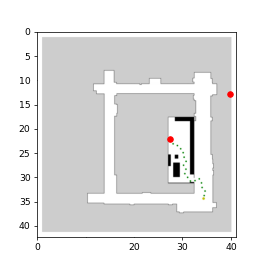

In [20]:
'''Initialisation variables et graphique'''
cmd_pos = []

########################################## LABEL COMMANDE ##########################################

Label_automatique = widgets.Button(
    description='Commande automatique',
    layout=Layout(width='100%', height='40px'),
    disabled=False,
    button_style='info',
    )

Label_manuel = widgets.Button(
    description='Commande manuelle',
    layout=Layout(width='100%', height='40px'),
    disabled=False,
    button_style='info',
    )

Label_etat = widgets.Button(
    description=texte_etats_robot,
    layout=Layout(width='80%', height='100%'),
    disabled=False,
    button_style='',
    )

########################################## COMMANDE BUT ##########################################

''' Commande de la coordonee de but '''
Cmd_coord_x = widgets.BoundedFloatText(
    value = 35,
    min = 0,
    max = 500,
    step=0.1,
    description='Position X : ',
    disabled=False
)

Cmd_coord_y = widgets.BoundedFloatText(
    value = 35,
    min = 0,
    max = 500,
    step=0.1,
    description='Position Y : ',
    disabled=False
)

'''Création des boutons'''
Cmd_arret = widgets.Button(
    description='ARRETER',
    disabled=False,
    button_style='danger',
)

Cmd_plan = widgets.Button(
    description='PLANIFIER',
    disabled=False,
    button_style='info',
)

Cmd_aller = widgets.Button(
    description='ALLER',
    disabled=False,
    button_style='success',
)

'''Activation de l'intération des boutons '''
Cmd_arret.on_click(thread_button_stop)
Cmd_plan.on_click(thread_button_plan)
Cmd_aller.on_click(thread_button_start)

########################################SUIVI DE LA CAMERA#########################################


''' Feed de la camera '''
camera = widgets.Image(value=cam_msg.data,
                      format="png",
                       height="100%",
                       width="100%",
                       justify_content='center')
def update_camera():
    while True:
        camera.value=cam_msg.data
        time.sleep(0.1)

thread_camera = threading.Thread(target=update_camera)
thread_camera.start()

########################################## Vitesse et position ##########################################
''' Commande de la vitesse '''
Cmd_vitesse = widgets.FloatSlider(value= 0.3,
                                  min  = 0.2,
                                  max  = 0.5,
                                  step=0.1,
                                  description='Vitesse : ',
                                  disabled = False,
                                  continuous_update=False,
                                  orientation='horizontal',
                                  readout=True,
                                  readout_format='.1f')

#Modifie les paramètres de vitesse du robot
#Appel de la méthode à une certaine fréquence pour ne pas entrer en conflif avec la commande
def update_velocitie():
    global vel_lin, vel_ang
    rate = rospy.Rate(frequence)
    while True:
        vel_lin=Cmd_vitesse.value
        vel_ang=Cmd_vitesse.value*2
        rate.sleep()

thread_vel = threading.Thread(target=update_velocitie)
thread_vel.start()

######################################Contrôle bouton #################################################
btn_up = widgets.Button(icon='arrow-up')
btn_up.layout.height = '30px'
btn_left = widgets.Button(icon='arrow-left')
btn_left.layout.height = '30px'
btn_down = widgets.Button(icon='arrow-down')
btn_down.layout.height = '30px'
btn_right = widgets.Button(icon='arrow-right')
btn_right.layout.height = '30px'
btn_stop = widgets.Button(description='Stop')
btn_stop.layout.height = '30px'
    
btn_up.on_click(thread_button_up)
btn_left.on_click(thread_button_left)
btn_down.on_click(thread_button_down)
btn_right.on_click(thread_button_right)
btn_stop.on_click(thread_button_stop)

############################### MAP ############################

'''Affichage de la carte avec le parcours'''
#Output permet d'afficher une figure
output = widgets.Output()
centerAutomatique = widgets.HBox([output], layout=widgets.Layout(flex='1', justify_content='center'))


''' Image de la carte '''
ImageMapFile = open("a2230_map_closed.png", "rb")
ImageMap = ImageMapFile.read()
ImageMapFile.close()
Map = widgets.Image(value=ImageMap,
                    format='png',
                    width=150,
                    height=150)


####################### Position de départ du robot ########################
select_pos = widgets.Dropdown(
    options=['1', '2', '3','4', '5', '6', '7', '8'],
    value='4', #Position par défaut
    description='Case départ',
    disabled=False,
)

####################### INTERFACE MANUELLE ET AUTOMATIQUE ########################


''' Center manuel '''
footerManuel = GridspecLayout(3,3)
footerManuel[0,1] = btn_up
footerManuel[1,0] = btn_left
footerManuel[1,2] = btn_right
footerManuel[2,1] = btn_down
footerManuel[1,1] = btn_stop

''' Header Manuel '''
centerManuel = GridspecLayout(9,3)
centerManuel[0,0] = Label_manuel
centerManuel[0:2,2] = Label_etat
centerManuel[2:4,2] = output_label_tag
centerManuel[1,0] = Cmd_vitesse
centerManuel[2:8,0:2] = camera

''' Header Automatique '''
headerAutomatique = GridspecLayout(4,3)
headerAutomatique[0,0] = Label_automatique
headerAutomatique[0:2,2] = Label_etat
headerAutomatique[2:4,2] = output_label_tag
headerAutomatique[1,0] = Cmd_vitesse
headerAutomatique[2,0] = Cmd_coord_x
headerAutomatique[3,0] = Cmd_coord_y
headerAutomatique[1,1] = Cmd_arret
headerAutomatique[2,1] = Cmd_plan
headerAutomatique[3,1] = Cmd_aller

''' Disposition generale Manuel '''
Manuel = AppLayout(header=None,
                   left_sidebar=None,
                   center=centerManuel,
                   right_sidebar=None,
                   footer=footerManuel,
                  )

''' Disposition generale Automatique '''
Automatique = AppLayout(header=headerAutomatique,
                        left_sidebar=None,
                        center=None, #centerAutomatique,#Had if you want to don't show the map
                        right_sidebar=None,
                        footer=select_pos,
                       )


''' Onglets de controle Manuel/Automatique '''
ControlNest = widgets.Tab()
ControlNest.title = ['Automatique','Manuel']  # Ne fonctionne pas avec la version actuelle 
ControlNest.children = [Automatique, Manuel]
display(ControlNest)
    
################# SUIVI DE LA POSITION DU ROBOT ###################

#Fonction d'initialisation de l'emplacement de la carte dans une figure interactive
def setup_follow_map():
    global fig_c, ax_pos_current
    %matplotlib notebook  
    fig_c, ax_pos_current = plt.subplots(figsize=(4,4), num=1, clear=True, sharex=True, sharey=True)
    
#Fonction d'attente de plannification de la carte pas l'utilisateur
def fun_wait_for_follow_map():
    global fig_c, ax_pos_current
    while(flag_follow_map == False):
        time.sleep(0.001)
    setup_follow_map()
    while True:
        debug = launch_follow_map()
        time.sleep(1)
        print('Nouvelle itération')

#Fonction d'animation du point interacif sur la figure
def animate(point_actuel):
    global ax_pos_current, fig_c 
    point_actuel.set_data([x-0.3],[y-0.2])
    ax_pos_current.draw_artist(point_actuel)
    fig_c.canvas.blit(ax_pos_current.bbox) # Permet de ne modifier qu'une partie de l'image afin de demander moins de ressources
    plt.pause(0.8)

#Fonction principale, permet l'affichage, la gestion de la plannification et l'animation
def launch_follow_map():
    global new_plannification, plannification_in_progress, fig_c,ax_pos_current
    print('Charge image') 
    try:
        image_travel_read = mpimg.imread(image_travel)
        ax_pos_current.imshow(image_travel_read, extent=([0, x_len, y_len, 0]))
    except:
        print("Something went wrong when writing to the file")       
    
    point_actuel, = ax_pos_current.plot([], [], 'ro')
    fig_c.canvas.draw_idle()
    new_plannification = False
    while True:
        if new_plannification == True:
            print(f'Nouvelle plannification: {new_plannification}')
            new_plannification = False
            ax_pos_current.clear()
            plt.draw()
            return 0
        else:
            animate(point_actuel)



thread__follow = threading.Thread(target=fun_wait_for_follow_map)
thread__follow.start()



